# Lab Assignment Six: Convolutional Network Architectures

## Preparation
### Getting data in

In [1]:
import pandas as pd
test_labels = pd.read_csv('test_labels.csv')
train_labels = pd.read_csv('train_labels.csv')


y_train = train_labels["Volcano?"].values
y_test = test_labels["Volcano?"].values


from numpy import genfromtxt
X_train = genfromtxt('train_images.csv', delimiter=',')
X_test = genfromtxt('test_images.csv', delimiter=',')

h=w=110
train_labels["Volcano?"].value_counts()

0    6000
1    1000
Name: Volcano?, dtype: int64

In [2]:
import numpy as np

X_train = X_train.astype(np.float32)/12 - 8.2
X_test = X_test.astype(np.float32)/12 - 8.2

### Oversampling data

In [3]:
import numpy as np
volc_ids = y_train.nonzero()
y_o_train = np.concatenate([y_train, y_train[volc_ids],y_train[volc_ids],y_train[volc_ids],y_train[volc_ids],y_train[volc_ids]])
X_o_train = np.concatenate([X_train, X_train[volc_ids],X_train[volc_ids],X_train[volc_ids],X_train[volc_ids],X_train[volc_ids]])
print(y_o_train.nonzero()[0].size)
print(y_o_train.size)

6000
12000


### Dataset example

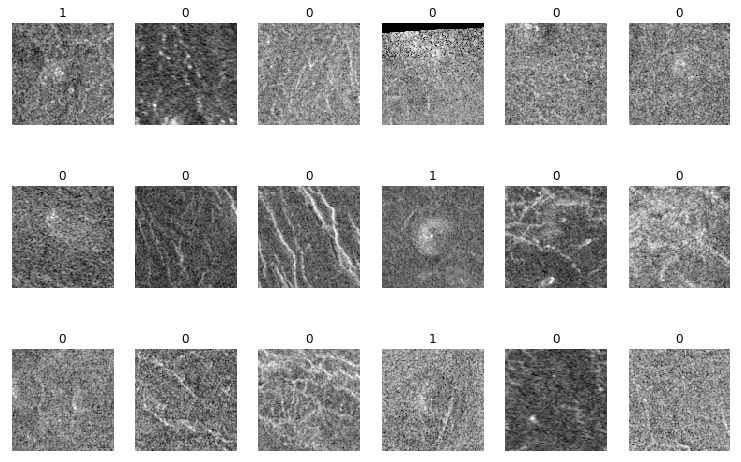

In [4]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_o_train, y_o_train, h, w) # defaults to showing a 3 by 6 subset of the images

### Performance metric
High accuracy of volcanoes is a priority for this case. The reason for this is that recall is important because every volcano can reveal different eras in history of the planet. Precision is important too because we want to study volcanoes separately from other land features. F1 score would not be needed since the class imbalance is easily removed from this binary classification. 

The reason accuracy of volcanoes on Venus is so important is so we can understand the processes that helped shape our own planet. Since the characteric size, mass and composition are almost the same the formation of volcanoes are very similar to our own planet's past and can help us understand the role volcanoes had in creating life on Earth. In the future, we can analyze these volcanoes to determine areas where life or rare minerals may be.

### Training and testing method
Training and testing strategy would be shuffled with 5 folds. This would be a good idea because the class imbalance is removed. This would be realistic to how the algorithm would be used because lots of random sample data (including Earth's volcanoes for training) are used to sift through large amounts of non-volcanic test data.

### Subsampling

In [5]:
import numpy as np
ids = np.arange(12000)
np.random.shuffle(ids)
X_train_trunc = X_o_train[ids[:800]]
y_train_trunc = y_o_train[ids[:800]]

ids = np.arange(2734)
np.random.shuffle(ids)

X_test_trunc = X_test[ids[:200]]
y_test_trunc = y_test[ids[:200]]

print("Volcanoes in train out of 80:", y_train_trunc.nonzero()[0].size)

Volcanoes in train out of 80: 405


# Modeling

In [6]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

keras.__version__

/home/aviraj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.4'

In [7]:
NUM_CLASSES = 2
y_train_ohe = keras.utils.to_categorical(y_train_trunc, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test_trunc, NUM_CLASSES)

#### Add precision function (from stack overflow)

In [8]:
import functools
from keras import backend as K
import tensorflow as tf
def as_keras_metric(method):
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
precision = as_keras_metric(tf.metrics.precision)

#### Add data expansion strategy
Since images of volcanoes are mostly identified by the discoration and textured circular bump the best way to add resiliency is to add random discolaration and change of pixel textures. Rotation and translation will not make much improvement to the classification.

### CNN

In [9]:
# make a CNN with conv layer and max pooling
def build_cnn():
    cnn = Sequential()
    cnn.add(Reshape((1,110,110), input_shape=(1,12100)))
    cnn.add(Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,110,110)))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    # add one layer on flattened output
    cnn.add(Flatten())
    cnn.add(Dense(NUM_CLASSES))
    cnn.add(Activation('softmax'))
    cnn.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=["accuracy"])
    return cnn

cnn = build_cnn()
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 110, 110)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 110, 16)        7056      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 110, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 55, 8)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 440)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 882       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total para

In [10]:
from sklearn.model_selection import KFold



def cross_validate(build_cnn,is_cnn = True):
    # Instantiate the cross validator
    kf = KFold(n_splits=5, shuffle=True)

    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(kf.split(X_train, y_train)):
        print("Training on fold " + str(index+1) + "/5...")

        # Generate batches from indices
        xtrain, xval = X_train[train_indices], X_train[val_indices]
        ytrain, yval = y_train[train_indices], y_train[val_indices]

        # Clear model, and create it
        cnn = None
        cnn = build_cnn()
        
        if is_cnn:
            history = cnn.fit(np.expand_dims(X_train_trunc, axis=1), y_train_ohe,
                        batch_size=32, epochs=25,
                        shuffle=True, verbose=0,
                        validation_split=0.2)
        else:
            history = cnn.fit(X_train_trunc, y_train_ohe,
                        batch_size=32, epochs=25,
                        shuffle=True, verbose=0,
                        validation_split=0.2)
        accuracy_history = history.history['acc']
        val_accuracy_history = history.history['val_acc']
        print("Last training accuracy: " + str(accuracy_history[-1]) + ", last validation accuracy: " + str(val_accuracy_history[-1]))
    return history

history = cross_validate(build_cnn)


Training on fold 1/5...
Last training accuracy: 1.0, last validation accuracy: 0.825
Training on fold 2/5...
Last training accuracy: 1.0, last validation accuracy: 0.84375
Training on fold 3/5...
Last training accuracy: 1.0, last validation accuracy: 0.85
Training on fold 4/5...
Last training accuracy: 1.0, last validation accuracy: 0.8
Training on fold 5/5...
Last training accuracy: 0.99375, last validation accuracy: 0.8125


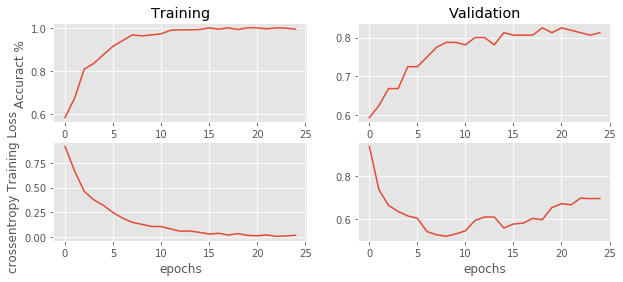

In [11]:
from matplotlib import pyplot as plt

def plot_loss_acc(history):

    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['acc'])

    plt.ylabel('Accuract %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('crossentropy Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
plot_loss_acc(history)

### Architecture Investigation and comparison
#### Increase kernal size

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 1, 110, 110)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 110, 16)        15856     
_________________________________________________________________
activation_13 (Activation)   (None, 1, 110, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 55, 8)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 440)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 882       
_________________________________________________________________
activation_14 (Activation)   (None, 2)                 0         
Total para

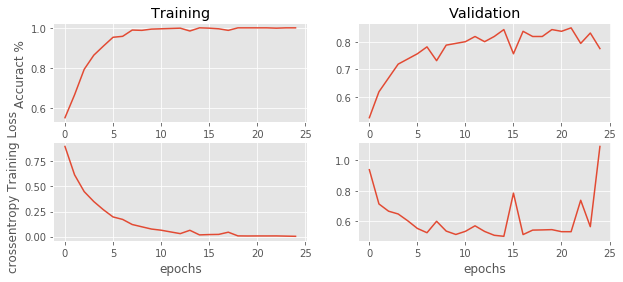

In [12]:
# make a CNN with increase kernal size
def build_cnn2():
    cnn2 = Sequential()
    cnn2.add(Reshape((1,110,110), input_shape=(1,12100)))
    cnn2.add(Conv2D(filters=16, kernel_size= (3, 3), padding='same', input_shape=(1,110,110)))
    cnn2.add(Activation('relu'))
    cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    # add one layer on flattened output
    cnn2.add(Flatten())
    cnn2.add(Dense(NUM_CLASSES))
    cnn2.add(Activation('softmax'))
    cnn2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=["accuracy"])
    return cnn2

cnn2 = build_cnn2()
cnn2.summary()
history2 = cross_validate(build_cnn2)
plot_loss_acc(history2)

#### Add dropout, another layer on flattened output, and another convolutional layer (AlexNet)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 1, 110, 110)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 110, 110)      320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 110, 64)       63424     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 55, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 55, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 56320)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               7209088   
__________

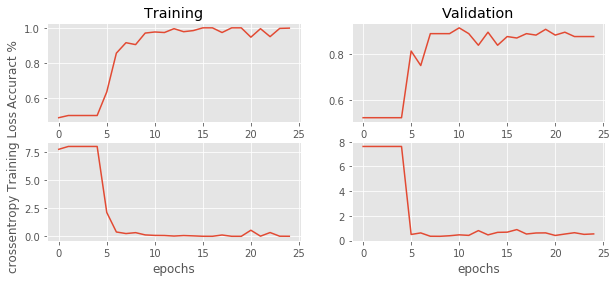

In [13]:
# Alex Net
def build_cnn3():
    cnn3 = Sequential()

    # let's start with an AlexNet style convolutional phase
    cnn3.add(Reshape((1,110,110), input_shape=(1,12100)))
    cnn3.add(Conv2D(filters=32,
                    input_shape = (1,110,110),
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu', data_format="channels_first")) # more compact syntax

    # no max pool before next conv layer!!
    cnn3.add(Conv2D(filters=64,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu')) # more compact syntax
    cnn3.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))


    # add one layer on flattened output
    cnn3.add(Dropout(0.25)) # add some dropout for regularization after conv layers
    cnn3.add(Flatten())
    cnn3.add(Dense(128, activation='relu'))
    cnn3.add(Dropout(0.5)) # add some dropout for regularization, again!
    cnn3.add(Dense(NUM_CLASSES, activation='softmax'))

    # Let's train the model 
    cnn3.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                  optimizer='rmsprop', # 'adadelta' 'rmsprop'
                  metrics=['accuracy'])

    return cnn3

cnn3 = build_cnn3()
cnn3.summary()
history3 = cross_validate(build_cnn3)
plot_loss_acc(history3)

#### Interpretation of Performance
The cnn with just a larger kernal size performs at about 80% accuracy while the one with extra convolutional and normal layer performs at aroun 87.5%.
Some folds have much lower accuracy for the second at around 50%. This means that the second cnn is more sensitive to the dataset or got a data set that did not generalize well. Both networks start converging at around 5 epochs for validation and training for accuracy and binary cross entropy.

### Compare to Multilayer Perceptron

In [14]:
# make a 3 layer keras MLP
def build_mlp():
    mlp = Sequential()
    mlp.add( Dense(input_dim=X_train_trunc.shape[1], units=30, activation='relu') )
    mlp.add( Dense(units=15, activation='relu') )
    mlp.add( Dense(NUM_CLASSES) )
    mlp.add( Activation('softmax') )

    mlp.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return mlp

mlp = build_mlp()
mlp.fit(X_train_trunc, y_train_ohe,
        batch_size=32, epochs=150,
        shuffle=True, verbose=0)

cnn2  = build_cnn2()
cnn2.fit(np.expand_dims(X_train_trunc, axis=1), y_train_ohe,
                batch_size=32, epochs=150,
                shuffle=True, verbose=0,
                validation_split=0.2)

#### Compare loss and accuracy

Training on fold 1/5...
Last training accuracy: 0.9390625, last validation accuracy: 0.84375
Training on fold 2/5...
Last training accuracy: 0.915625, last validation accuracy: 0.83125
Training on fold 3/5...
Last training accuracy: 0.9203125, last validation accuracy: 0.7125
Training on fold 4/5...
Last training accuracy: 0.9515625, last validation accuracy: 0.76875
Training on fold 5/5...
Last training accuracy: 0.9578125, last validation accuracy: 0.81875


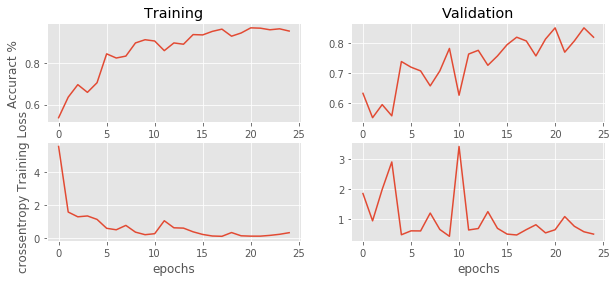

In [15]:
history_mlp = cross_validate(build_mlp,False)
plot_loss_acc(history_mlp)

#### Setup an ROC curve

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


y_pred_keras = mlp.predict_proba(X_test_trunc).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_trunc, y_pred_keras[200:])
auc_keras = auc(fpr_keras, tpr_keras)



y_pred_cnn = cnn3.predict_proba(np.expand_dims(X_test_trunc, axis=1)).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test_trunc, y_pred_cnn[200:])
auc_cnn = auc(fpr_cnn, tpr_cnn)

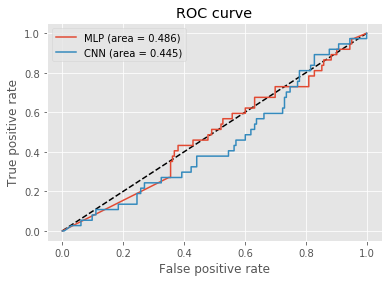

In [42]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='MLP (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Interpretation
The mlp takes longer to converge to around 80%. The mlp seems to have a higher area under the curve than a CNN in the ROC graph especially for false positive rates between 0.3 to 0.7.